In [1]:
import numpy as np
import random
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from skimage.transform import resize
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.layers import Activation, Dense, Input, Dropout, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Layer
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import metrics
from keras.applications.inception_v3 import preprocess_input, InceptionV3
import keras.backend as K

Using TensorFlow backend.


In [2]:
## Constants
OLD_IMAGE_DIMS = (218, 178, 3)
NEW_IMAGE_DIMS = (64, 64, 3)
#CROP_IMAGE_DIMS = (25, 45, 153, 173)
BATCH_SIZE = 128
N = 6
NUM_ATTRIBUTES = 40
NUM_BATCHES = 1
LATENT_DIM = 64
TOT_IMAGES = 202599
EPOCHS = 1

In [3]:
## Constants needed to run in Google Colab
PATH = './'
IMAGES = 'img_align_celeba/'
ATTRIBUTES = 'list_attr_celeba.txt'

In [4]:
## Loading dataset
def get_attributes(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    attributes = []
    attr = []
    i = 0
    for line in lines:
        if i != 0 and i != 1:
            line = line.split()
            #line.pop(0)
            attributes.append(line)
        i += 1
    for i in range(len(attributes)):
        for j in range(len(attributes[i])):
            if attributes[i][j] == '-1':
                attributes[i][j] = '0'
    return attributes

def initialize_training_set(): 
    all_attributes = get_attributes(PATH + ATTRIBUTES)
    
    while True:
        chosen_info = random.sample(all_attributes, N)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        resized_images = []
    
        for ind in range(len(chosen_info)):
            image_path = PATH + IMAGES + chosen_images[ind]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        chosen_attributes = np.array(chosen_attributes, dtype=np.float32)

        yield [resized_images, chosen_attributes], None 
        
def initialize_test_set():
    all_attributes = get_attributes(PATH + ATTRIBUTES)
    info_in_batches = []
    attributes_in_batches = []
    images_in_batches = []
    test_set = []
    
    for i in range(NUM_BATCHES):
        chosen_info = random.sample(all_attributes, BATCH_SIZE)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        
        info_in_batches.append(chosen_info)
        attributes_in_batches.append(chosen_attributes)
        images_in_batches.append(chosen_images)
        
    for i in range(NUM_BATCHES):
        chosen_images = images_in_batches[i]
        attributes = attributes_in_batches[i]
        resized_images = []
        
        for j in range(BATCH_SIZE):
            image_path = PATH + IMAGES + chosen_images[j]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        attributes = np.array(chosen_attributes, dtype=np.float32)

        test_set.append([resized_images, attributes])
    return test_set

training_set = initialize_training_set()
test_set = initialize_test_set()

['000001.jpg', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:

class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def VAE():
  #Define encoder model.
  input_img = Input(shape = NEW_IMAGE_DIMS, name='input_img')
  labels = Input(shape = (NUM_ATTRIBUTES,), name='labels')

  x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(input_img)
  x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 512, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)

  #encode = Encode_Decode(input_img) #Done

  shape_before_flattening = K.int_shape(x)[1:]
  #shape_before_flattening = K.int_shape(encode)[1:]

  x = Flatten()(x)

  z_mean = Dense(LATENT_DIM, name='z_mean')(x)
  z_log_sigma = Dense(LATENT_DIM, name='z_log_sigma')(x)
  z = Sampling()([z_mean, z_log_sigma])

  zy = Concatenate()([z, labels])

  inputs_embedding = Input(shape=(LATENT_DIM + NUM_ATTRIBUTES,))
  embedding = Dense(np.prod(shape_before_flattening))(inputs_embedding)
  embedding = Reshape(shape_before_flattening)(embedding)

  #Decoding
  x_ = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(embedding)
  x_ = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
  x_ = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
  x_ = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
  x_ = Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,  padding = 'same', activation = 'sigmoid')(x_)

  #x_hat = Encode_Decode(embedding)

  encoder = Model(inputs = [input_img, labels], outputs = zy, name="encoder")
  decoder = Model(inputs = inputs_embedding, outputs = x_, name="decoder")

  vae_out = decoder(encoder([input_img, labels]))

  rec_loss =  np.prod(NEW_IMAGE_DIMS) * binary_crossentropy(Flatten()(input_img), Flatten()(vae_out))
  kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
  vae_loss = K.mean(rec_loss + kl_loss)

  vae = Model(inputs = [input_img, labels], outputs = vae_out, name="vae")

  vae.add_loss(vae_loss)

  optimizer = Adam(lr=0.0005, beta_1 = 0.5)
  vae.compile(optimizer)

  return vae, encoder, decoder

vae, encoder, decoder = VAE()

encoder.summary()
decoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_img[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 8, 8, 128)    73856       conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [6]:
vae.fit(training_set, steps_per_epoch=TOT_IMAGES//BATCH_SIZE, verbose=1, epochs=EPOCHS)

Epoch 1/1
['000001.jpg', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1']
1582/1582 [==============================] - 499s 316ms/step - loss: 7125.1662


In [7]:
# Save model weights
vae.save_weights('./vae.h5')
decoder.save_weights('./decoder.h5')
encoder.save_weights('./encoder.h5')

In [26]:
# Calculate Frechet Inception Distance (https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/)

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [9]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg')#, input_shape=(299,299,3))

In [47]:
def reconstruct_images(test_set):
    images = []
    predictions = []
    
    index = 1
    print(test_set[0])
    
    for batch in test_set:
        print('Investigating batch', index)
        resized_images = batch[0] #* 255.0
        prediction = vae.predict(batch) #* 255.0
        
        # Scaling images
        original_images = scale_images(resized_images, (299, 299, 3))
        predicted_images = scale_images(prediction, (299, 299, 3))
        
        # Pre-processing images
        original_images = preprocess_input(original_images)
        predicted_images = preprocess_input(predicted_images)
        
        images.append(original_images)
        predictions.append(predicted_images)
                      
        index += 1

    return resized_images, prediction, images, predictions
        
resized_images, prediction, images, predictions = reconstruct_images(test_set) # Kall dette bedre ting


[array([[[[9.11764726e-02, 4.41176482e-02, 8.62745121e-02],
         [3.33333351e-02, 7.84313772e-03, 2.54901964e-02],
         [3.72549035e-02, 1.27450982e-02, 5.88235306e-03],
         ...,
         [5.34313738e-01, 3.92156869e-01, 2.63725489e-01],
         [7.86274493e-01, 5.71568608e-01, 3.97058815e-01],
         [7.72549033e-01, 5.50980389e-01, 3.51960778e-01]],

        [[1.86274517e-02, 9.80392215e-04, 1.66666675e-02],
         [2.15686280e-02, 8.82352982e-03, 1.47058824e-02],
         [1.07843140e-02, 0.00000000e+00, 0.00000000e+00],
         ...,
         [7.34313726e-01, 5.82352936e-01, 3.79411757e-01],
         [7.53921568e-01, 5.70588231e-01, 3.64705890e-01],
         [7.01960802e-01, 4.96078432e-01, 2.72549033e-01]],

        [[1.66666675e-02, 1.96078443e-03, 9.80392215e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.90196096e-03, 0.00000000e+00],
         ...,
         [7.55882382e-01, 5.90196073e-01, 3.82352948e-01],
         

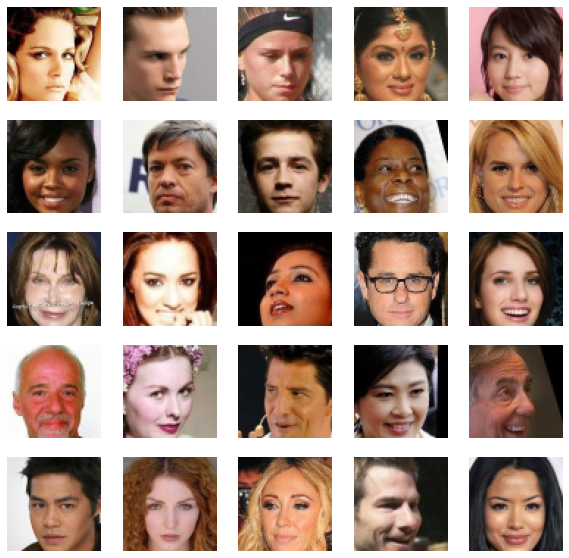

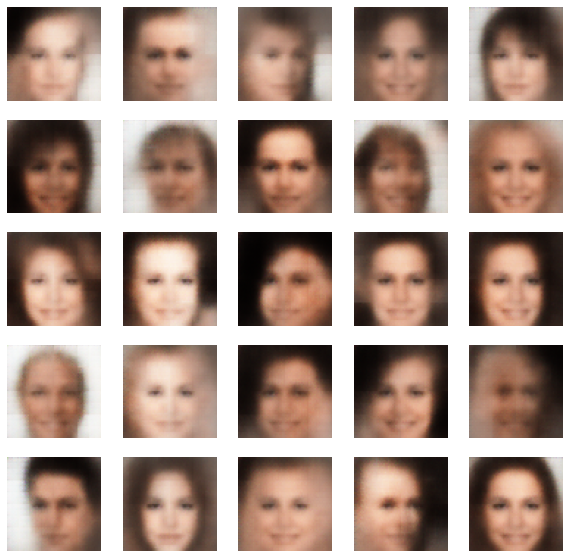

In [22]:
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    
show_batch(resized_images)
show_batch(prediction)

In [27]:
print("Calculating score for reconstruction...")
fid_score = calculate_fid(model, images, predictions)
print("Done!")
print("Score for reconstruction:")
print(fid_score)

Calculating score for reconstruction...
Done!
Score for reconstruction:
2.362931360958134


In [90]:
## Generating a new face

def generate_images():
    predictions = []
    
    index = 1
    
    generated_attributes = np.zeros(NUM_ATTRIBUTES, dtype=np.float32)
    generated_attributes[8] = 1   # black hair
    generated_attributes[31] = 1  # smiling
    
        
    for i in range(NUM_BATCHES):
        images = []
            
        for j in range(BATCH_SIZE):
            generated_image = np.random.uniform(-1, 1, size=(LATENT_DIM*LATENT_DIM)).astype(np.float32)
            images.append(generated_image)
            
        for j in range(BATCH_SIZE):
            batch = []
            
            batch.append(images[j])
            batch.append(generated_attributes)
            
            """
            for k in range(len(images[j])):
                pixels = images[j]
                batch.append(pixels[k])
            for i in range(NUM_ATTRIBUTES):
                batch.append(generated_attributes[i])"""

            print('h',np.array(batch).shape)

            prediction = decoder.predict(np.array(batch))

            predicted_images = scale_images(prediction, (299, 299, 3))
            predicted_images = preprocess_input(predicted_images)
            predictions.append(predicted_images)
        
    return generated_image, prediction, images, predictions
        
        
generated_image, prediction, images, predictions = generate_images()

show_batch(prediciton)


h (2,)


ValueError: Error when checking input: expected input_1 to have shape (104,) but got array with shape (1,)

In [63]:
z_sample = np.random.randn(10000, LATENT_DIM).astype(np.float32)
#print(z_sample)


#attributes = np.array(pd.read_csv(Library + ATTRIBUTE_FILE, skiprows=2, header=None, delim_whitespace=True))
#attributes = attributes[np.random.choice(attributes.shape[0], 10000, replace=False)][:, 1:]
attributes = get_attributes(PATH + ATTRIBUTES)
label = attributes


label = np.full(shape=(10000,40), fill_value=-1, dtype=np.int32)
label[:, 32] = 1
label[:, 9] = 1

z = np.concatenate((z_sample, label), axis=1)
#print(z)

batched = 0
count = 0
pred_act = np.array([]).reshape((0, 2048))
while batched < 10000:
  count += 1
  z_batch = z[batched: batched + BATCH_SIZE]
  print(z_batch)
  print("Batch", count, "- Num. samples:", z_batch.shape[0])
  predictions = decoder.predict(z_batch)
  if count == 1:
    prediction1 = predictions
  predictions = predictions * 255.0
  images2 = scale_images(predictions, (299, 299, 3))
  images2 = preprocess_input(images2)
  a = inception_model.predict(images2)
  pred_act = np.concatenate((pred_act, a), axis = 0)
  batched += Batch_Size

show_batch(prediction1)
"""
"""

['000001.jpg', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1']
[[ 0.04781651 -0.16943045 -1.69046044 ... -1.         -1.
  -1.        ]
 [-0.66953689 -1.00823915  1.51218295 ... -1.         -1.
  -1.        ]
 [ 0.99269128 -0.93427277 -1.57515609 ... -1.         -1.
  -1.        ]
 ...
 [ 0.45681444  1.23895705 -1.4686271  ... -1.         -1.
  -1.        ]
 [-2.69177055  0.58572882 -2.88377762 ... -1.         -1.
  -1.        ]
 [ 1.07033861  0.60671794  1.49135804 ... -1.         -1.
  -1.        ]]
Batch 1 - Num. samples: 128


NameError: name 'inception_model' is not defined